# Inflation rate prediction

## import libraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from xgboost import plot_importance

In [31]:
plt.rcParams['figure.figsize'] = [10,9]

## Read data

In [32]:
data = pd.read_excel("InflationsHistorical.xlsx")
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 137 non-null    datetime64[ns]
 1   Core CPI             137 non-null    float64       
 2   Fruits & Vegetables  137 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.3 KB


,Date,Core CPI,Fruits & Vegetables
0,2011-01-11 10:00:00,0.001678,0.023805
1,2011-02-01 10:00:00,0.001134,-0.003334
2,2011-03-01 10:00:00,-0.001650,0.195990
3,2011-04-01 09:00:00,0.008472,0.059881
4,2011-05-01 09:00:00,0.005371,-0.044851
...,...,...,...
132,2022-02-28 00:00:00,0.011640,0.151650
133,2022-03-31 00:00:00,0.030930,-0.018840
134,2022-04-30 00:00:00,0.024020,0.276020
135,2022-05-31 00:00:00,0.015890,-0.100630


In [33]:
data['Date'] = pd.date_range(start = '2011-01', end = '2022-06', freq='M')
data.set_index('Date', inplace = True)
data.sort_index(ascending = True, inplace = True)
data

,Core CPI,Fruits & Vegetables
Date,,
2011-01-31,0.001678,0.023805
2011-02-28,0.001134,-0.003334
2011-03-31,-0.001650,0.195990
2011-04-30,0.008472,0.059881
2011-05-31,0.005371,-0.044851
...,...,...
2022-01-31,0.011640,0.151650
2022-02-28,0.030930,-0.018840
2022-03-31,0.024020,0.276020


## Time series analysis

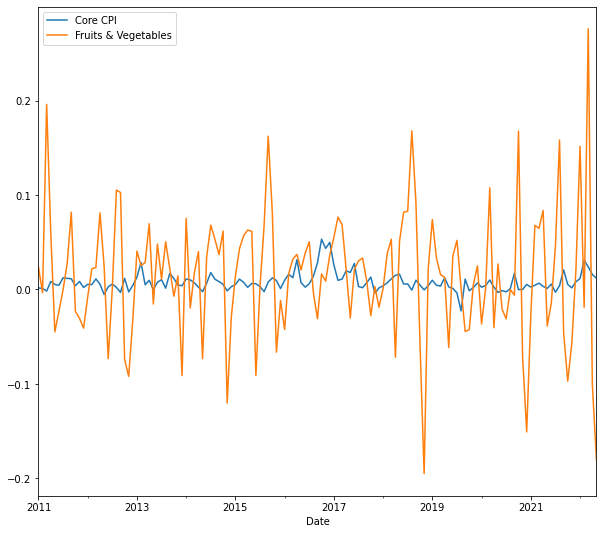

In [34]:
data.plot()
plt.show()

* clearly, the inflation rate for fruits & Vegetables is more volatile than the core change in inflation.
* Seasonality is present.
* Since the series is already being differenced that is why there is no clear trend. This implies stationarity.
Stationarity will be tested formally later

## Seasonality effect using the classical decompostion approach. 

additive model: $Y_t=T+S+C+e$

### Core CPI

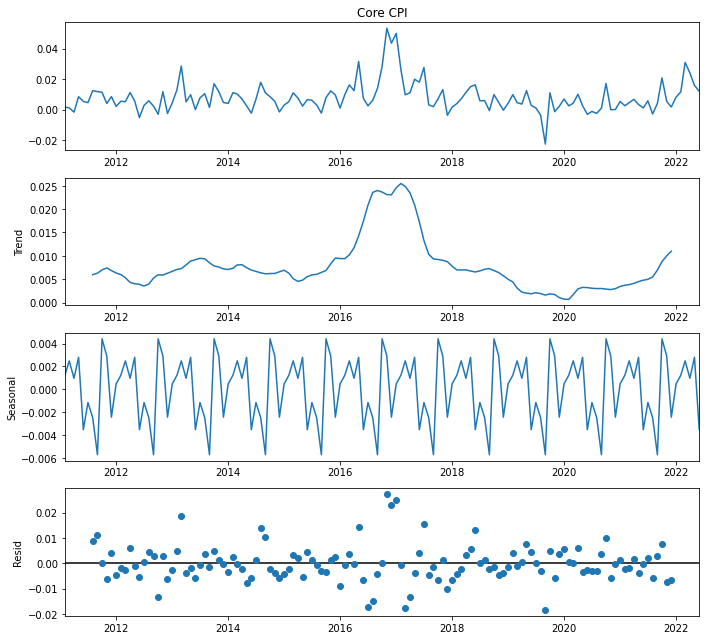

In [35]:
decomposition_cpi = sm.tsa.seasonal_decompose(data['Core CPI'], period = 12)
figure = decomposition_cpi.plot()
plt.show()

* There was no clear trend in the inflation rate until 2017 it increases significantly. This corresponds to the devaluation of the Egyptian Pound. 
* Seasonality is definetly present

Seasonal indices

In [36]:
def plot_seasonal_indices(decomposition, periods):
    seasonal_indices = decomposition.seasonal.head(periods)
    dates = seasonal_indices.index
    months = []
    for date in dates:
        months.append(date.month)

    fig, ax = plt.subplots(figsize = (10,12))

    ax.bar(x = months, height = seasonal_indices)

    for bar in ax.patches:
        ax.annotate(
            str(round(bar.get_height(),3)),
            (bar.get_x() + bar.get_width()/2, bar.get_height())
            )

    plt.ylabel('Seasonal index')
    plt.xlabel('Month')
    plt.show()

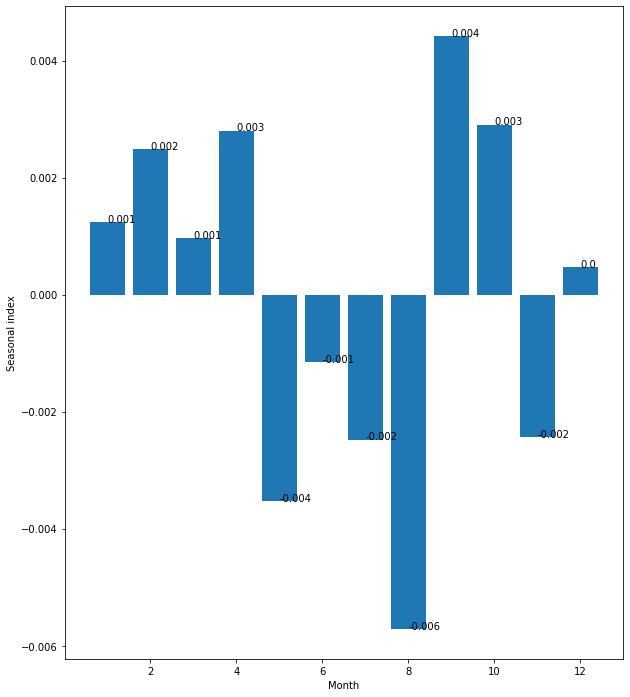

In [37]:
plot_seasonal_indices(decomposition_cpi, 12)

The most signifcant months that affect the inflation rate are 8&9. The inflation **rate** decreases by **0.006** on average in August and increases by **0.004** in September on average. These are the seasonal effects of each month. In addition to this, a rather obvious conclusion is that prices do start to increase at the first couple of months of the year then it starts to decrease during the second half of the Fiscal Year.  

### Fruits & Vegetables

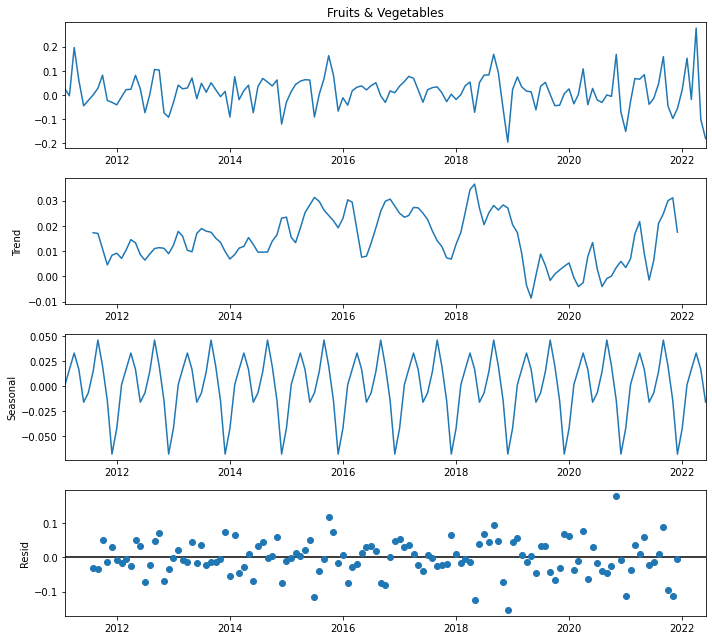

In [38]:
decomposition_fruits = sm.tsa.seasonal_decompose(data['Fruits & Vegetables'], period= 12)
decomposition_fruits.plot()
plt.show()

Seasonal indices

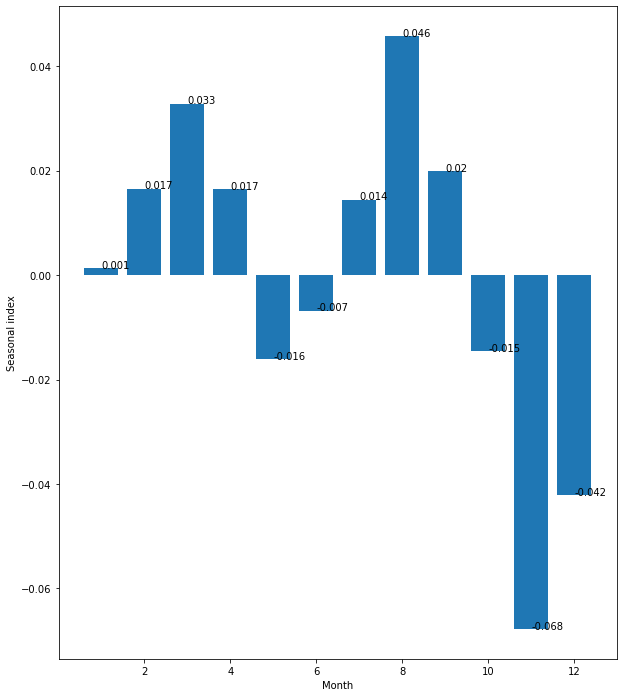

In [39]:
plot_seasonal_indices(decomposition_fruits, 12)

One can clearly observe the cyclical pattern. Apparently prices of fruits & vegetables decrease at the january and increases steadily during the spring and summer making a **0.046** increase in Sepetember. In November however, the inflation rate decreases by **0.068**. food prices increase at a much slower

## Forecasting

### Train-test split
leave last 10 months for testing 

In [40]:
y_train = data['Core CPI'].iloc[:-37]
y_test = data['Core CPI'].iloc[-37:,]

There are a lot of time-series forecasting techniques. The literature is so abundant of traditional methods, hybrid models, and advanced techniques; from classical Traditional methods to the modern Box-Jenkins Approach and lately, to the state of the art LSTM and Fourier-ANNs. There is a lot to explore and try out.

* The first appraoch undertaken here is a simple ARIMA model. 
* Second approach is hybrid ARIMA-Xgboost.

## ARIMA

### Check Stationarity 
Stationarity simply implies that the process that generated the series in non-stochastic/ not random. Every observation from random variable $Y_t$ comes from the same probabilitty denisty function. In other words, the moments of the distribution is constant. If all the momnets are constant this implies strong stationarity. if the mean and variance of a gaussian are constant and the covariance depends on time lag this implies strong stationarity.

A formal way to test stationarity is through Augmented Dickey-Fuller (ADF) test
* Null Hypothesis $(H_0)$: The series is non stationary
* Alternative Hypothesis $(H1)$: Alternative Hypothesis of the test is that the time series is stationary.

In [41]:
test_result = adfuller(data['Core CPI'])
print(f'p-value: {test_result[1]}')

p-value: 5.435975739134235e-08


Reject the null hypothesis. Luckily, the series is stationary and there is no need for differencing or log-transformation. 

we probably knew that already.

### Autocorrelation
To be able to determine the order of the arima model, autocorrelation and partial autocorrelation plots need to be checked.

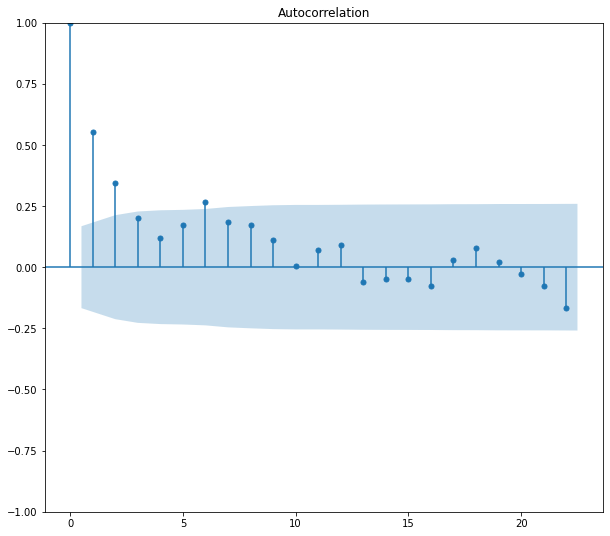

In [42]:
plot_acf(data['Core CPI']);

ACF cuts off after two lags. Therefore, 2 moving average term should be added for the arima model.  

c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


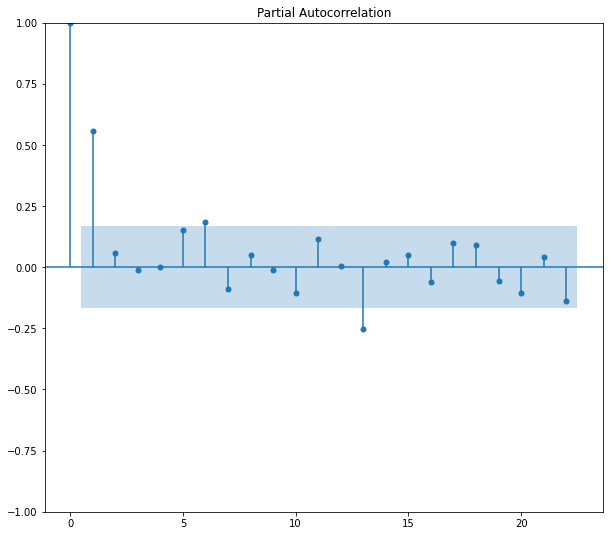

In [43]:
plot_pacf(data['Core CPI']);

PACF cuts off after one lag. This suggest that 1 Autoregressive term for the model

### ARIMA model
According to the autocorrelation plot, it is suitable to assume an autoregressive term and 2 Moving average term

* $\Phi(B)(1-B)^dy_t = \Theta(B)e_t$

* $y_t = \phi y_t-_1 + \theta e_t-_1 + \theta e_t-_2 + e_t$

In [44]:
arima0 = ARIMA(y_train, order = (1,0,2)).fit()
arima0.summary()

c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Core CPI   No. Observations:                  100
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 341.188
Date:                Thu, 15 Sep 2022   AIC                           -672.376
Time:                        17:39:08   BIC                           -659.350
Sample:                    01-31-2011   HQIC                          -667.104
                         - 04-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0090      0.002      3.825      0.000       0.004       0.014
ar.L1          0.4927      0.249      1.981      0.048       0.005       0.980
ma.L1          0.0984      0.264      0.372      0.710      -0.420       0.617
ma.L2          0.1105      0.200      0.552      0.581      -0.282       0.503
sigma2      6.331e-05   7.51e-06      8.432      0.000    4.86e-05     7.8e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                29.38
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                             0.81
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MA terms appear to be insignificant.

In [45]:
arima1 = ARIMA(y_train, order = (1,0,0)).fit()
arima1.summary()

c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Core CPI   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 340.880
Date:                Thu, 15 Sep 2022   AIC                           -675.761
Time:                        17:39:08   BIC                           -667.945
Sample:                    01-31-2011   HQIC                          -672.598
                         - 04-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.002      3.715      0.000       0.004       0.014
ar.L1          0.5904      0.065      9.028      0.000       0.462       0.719
sigma2      6.379e-05   7.15e-06      8.921      0.000    4.98e-05    7.78e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                35.21
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.88
Prob(H) (two-sided):                  0.08   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

$$y_t = 0.556 y_t-_1 + e_t

### Residual Diagnostics
Ideally, the residuals should resemble white noise. They should be normally distributed with mean of zero and variance constant. more importantly autocorrelation should be equal to zero across all lags. if not the model should then be respecified. 

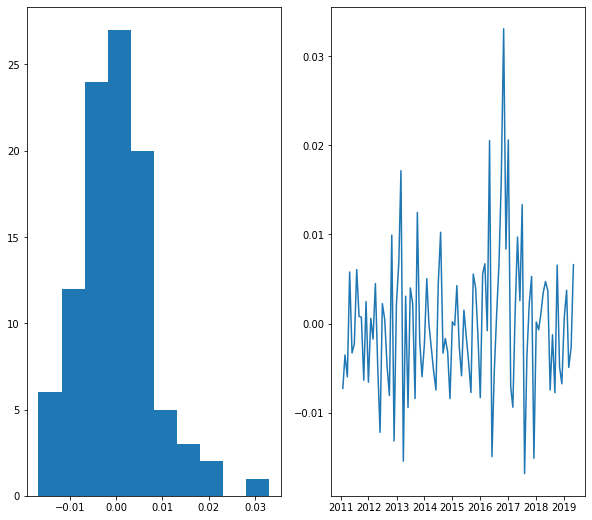

In [46]:
plt.subplot(1,2,1)
plt.hist(arima1.resid)

plt.subplot(1,2,2)
plt.plot(arima1.resid)
plt.show()

slightly fat tail plot. but all good.

### Visualize the model

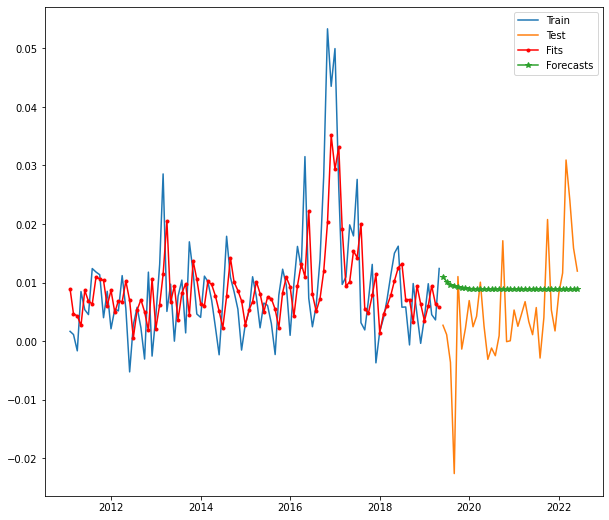

In [47]:
fig, ax = plt.subplots()
ax.plot(y_train, label = 'Train')
ax.plot(y_test, label = 'Test')
ax.plot(arima1.predict(), color = 'red', marker = '.', label = 'Fits')
ax.plot(arima1.forecast(37), marker = "*", label = 'Forecasts')
ax.legend()
plt.show()

### Evaluation metric:

$$RMSE = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n}(y-\hat y)^2}$$

In [48]:
def rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true.values - y_pred.values)**2))
    return rmse

In [49]:
print('train error:', rmse(y_train, arima1.predict()))
print('test error:', rmse(y_test, arima1.forecast(37)))

train error: 0.007998926023724347
test error: 0.009881931011071281


## Hybrid

Step 1 obtain arima estimates that is **$\hat y_t$** then add an estimate of the current error **$\hat e_t$** making  our final prediction as follows:

* **$\hat Y = \hat y_t+\hat e_t$**

* where $\hat y_t=\phi y_t-_1$ (Autoregression) as a base model
* random part will be modelled using (Gradient boosting) $\hat e_t = f(e_t-_1, e_t-_2,...)$ 

* Note that since the residuals are stationary, Gradient boosting, and trees generally will be able to extrapolate. 

In [50]:
def lags(x, lag):
    lags = pd.DataFrame()
    for i in range(1, lag+1):
        lagged = x.shift(i)
        lags[f'lag {i}'] = lagged
    return lags    

In [51]:
#Base Model (model_1)
model_1 = ARIMA(y_train, order = (1,0,0)).fit()

#Define features and target for model_2
y_train_model_2 = model_1.resid
X_train_model_2 = lags(model_1.resid,12)    #12 lag as features

#model_2
model_2 = XGBRegressor()
model_2.fit(X_train_model_2, y_train_model_2)

#Stacked model fits
y_fits_model_1 = model_1.predict()
y_fits_model_2 = model_2.predict(X_train_model_2)
y_final_fits = y_fits_model_1 + y_fits_model_2

#Stacked model predictions
y_pred_model_1 = model_1.forecast(37)
X_test_model_2 = lags(y_test - y_pred_model_1, 12)  #12 lags as features
y_pred_model_2 = model_2.predict(X_test_model_2)
y_final_pred = y_pred_model_1 + y_pred_model_2

c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Train error: 0.0004892215950513744, Test error: 0.01222056000183633


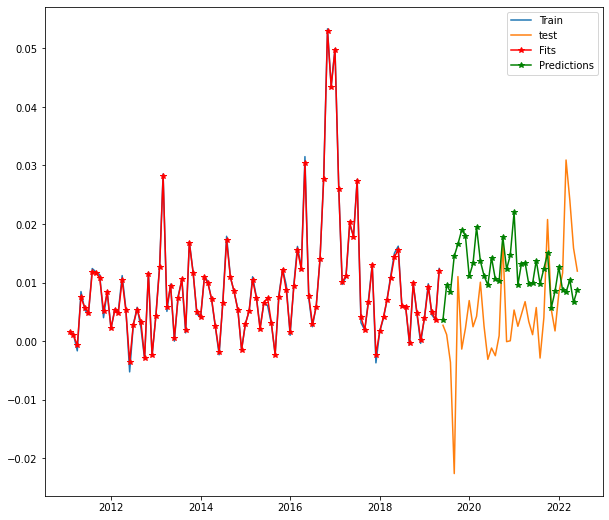

In [52]:
train_error, test_error = rmse(y_train, y_final_fits), rmse(y_test, y_final_pred)
print(f'Train error: {train_error}, Test error: {test_error}')
fig, ax = plt.subplots()
ax.plot(y_train, label = 'Train')
ax.plot(y_test, label = "test")
ax.plot(y_final_fits, label = 'Fits', color = 'red', marker = "*")
ax.plot(y_final_pred, marker = "*", label = 'Predictions', color = 'green')
ax.legend()
plt.show()

The model overfitted the data. one possible solution is to reduce the complexity of the model and tweak the regularization parameter.

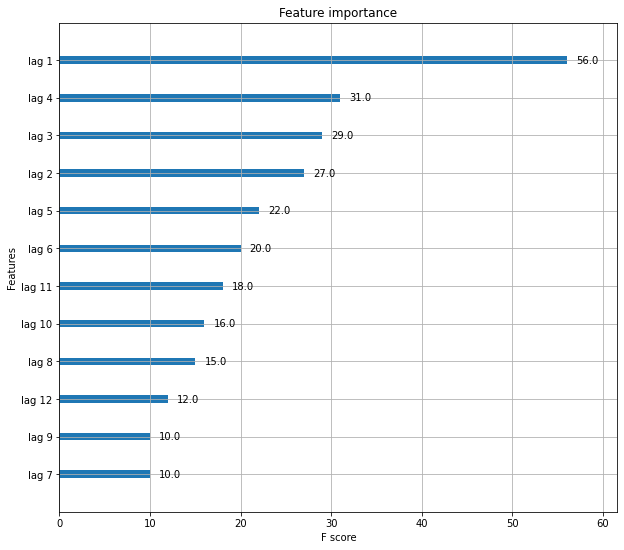

In [53]:
plot_importance(model_2);

First lag affects the prediction he most.  

### Save the train and test of model_2 for tuning

In [54]:
X_train_model_2.to_csv('X_train_model_2.csv', index = True)
y_train_model_2.to_csv('y_train_model_2.csv', index = True)

## Best params for Xgboost

In [92]:
#Base Model (model_1)
model_1 = ARIMA(y_train, order = (1,0,0)).fit()

#Define features and target for model_2
y_train_model_2 = model_1.resid
X_train_model_2 = lags(model_1.resid,12)    #12 lag as features

#model_2
model_2 = XGBRegressor(n_estimators = 19, learning_rate = 0.3, max_depth = 3, n_jobs = -1)
model_2.fit(X_train_model_2, y_train_model_2)

#Stacked model fits
y_fits_model_1 = model_1.predict()
y_fits_model_2 = model_2.predict(X_train_model_2)
y_final_fits = y_fits_model_1 + y_fits_model_2

#Stacked model predictions
y_pred_model_1 = model_1.forecast(37)
X_test_model_2 = lags(y_test - y_pred_model_1, 12)  #12 lags as features
y_pred_model_2 = model_2.predict(X_test_model_2)
y_final_pred = y_pred_model_1 + y_pred_model_2

train_error, test_error = rmse(y_train, y_final_fits), rmse(y_test, y_final_pred)
print(f'Train error: {train_error}, Test error: {test_error}')

c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\k_abo\Desktop\inflation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Train error: 0.003214032534537766, Test error: 0.013295717634030443


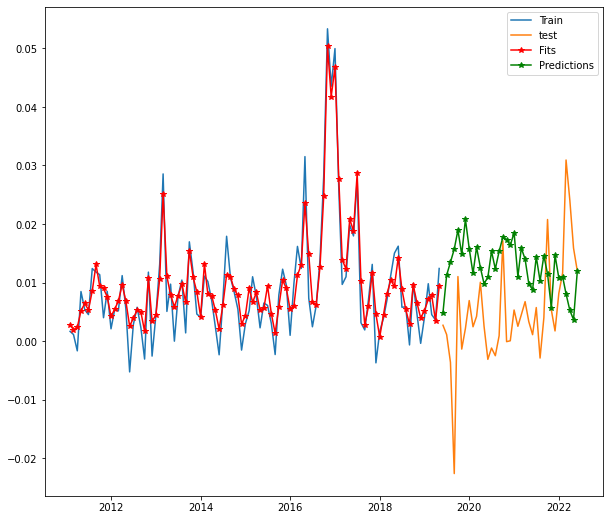

In [93]:
fig, ax = plt.subplots()
ax.plot(y_train, label = 'Train')
ax.plot(y_test, label = "test")
ax.plot(y_final_fits, label = 'Fits', color = 'red', marker = "*")
ax.plot(y_final_pred, marker = "*", label = 'Predictions', color = 'green')
ax.legend()
plt.show()

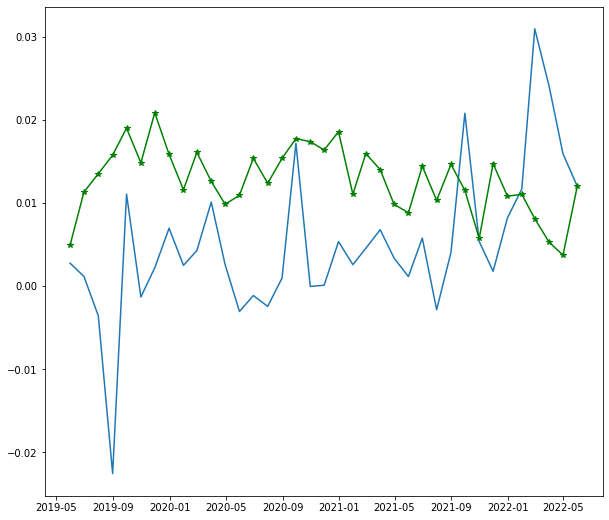

In [94]:
fig, ax = plt.subplots()
ax.plot(y_test, label = "test")
ax.plot(y_final_pred, marker = "*", label = 'Predictions', color = 'green')
plt.show()

### Limitations:
* The model is bad. 
* Not incorprating exogenous variables, including variables such interest rates and consumptions might be helpful.
* Difficulty in constructing confidence intervals 
* It is also prone to non-constant variance of the series. suggest log-transformation. 
* It cannot produce multistep forecasts
* More data is definitely needed.

Links:
1. https://www.mdpi.com/1996-1073/11/7/1687/htm
2. https://www.sciencedirect.com/science/article/pii/S1877050915006766
3. https://dataplatform.cloud.ibm.com/exchange/public/entry/view/ac820b22cc976f5cf6487260f4c8d9c8